# Time Series Analysis II

### 01/28/2022

| $\text{Type}$     | $\text{Maturity}$                        |
| ----------------- | ---------------------------------------- |
| $\text{Bill (b)}$ | $1\text{m} \leq \text{T} \lt 1\text{Y}$ |
| $\text{Note (N)}$ | $1\text{Y} \leq \text{T} \lt 10\text{Y}$  |
| $\text{Bond (B)}$ | $\quad\quad\ \ \text{T} \geq 10\text{Y}$ |

## What is a Constant Maturity Treasury?

According to [Investopedia](https://www.investopedia.com/terms/c/constantmaturity.asp), Constant Maturity is an adjustment for equivalent maturity, used by the Federal Reserve Board to compute an index based on the average yield of various Treasury securities, maturing at different periods.

One would use constant maturity yields as reference for pricing all kinds of depts or fixed income securities, fixed income securities being by far the largest type of security in U.S. securities markets.

## Nominal Yield Curve Rates vs. Real Yield Curve Rates

According to the Board of Governors of the Federal Reserve System, a [nominal Treasury security](https://www.federalreserve.gov/data/nominal-yield-curve.htm) is an issuance that specifies principal and interest as fixed dollar amounts to the holder. Since Treasury securities are backed by the full faith and credit of the U.S. government, the returns investors can earn on them are often used as a “risk-free” benchmark in finance research and investment practice. These securities are a promise to repay the principal (with interest if a note or a bond) to the holder (can be a public or private entity). Therefore, the real yield curve rate would be adjusted for inflation of interest rates, thereby used to determine risk-neutral cashflow.

The **nominal yield curve rate** adds a market average of the expected inflation risk premium to the real. Investors must be compensated for the risk of inflation in bond yields. The real yield determines the cashflow an investor in secondary markets can obtain by purchasing $\text{TIPS}$, which are Inflation Protected Securities offered by the U.S. Treasury department and other stakeholders that offer similar inflation protection to investors.

## Statement of Purpose

The purpose of this time series analysis is to work on the "next steps" highlighted under `Treas TS Analysis`. These steps are as follows:

1. Time-Series Forecasting
2. Cross-Validation and Testing on New Data
3. Vector Autoregressive Fractional Integrated Moving Average
4. Markov Chain Monte Carlo
5. Heteroscedastic Models
6. Fourier Analysis and Spectral Analysis

The first step subsequent to the analysis in `Treas TS Analysis` is to do forecasting. I would need to define a "forecast origin", how many steps I can take beyond the forecast origin and what is the prediction error. Hopefully, I have better forecasts than what I obtained in `Treas Exploratory Analysis` using a "top down" approach.

The second step is done to avoid "over-fitting" (more autoregressive parameters than observations) or "under-fitting" (less autoregressive parameters than observations). For time series, regressors, also known as "explanatory variables", are the lagged W values I found earlier, under `Treas TS Analysis`. There are other variables beyond the scope of the R-CMT and N-CMT rates explored in these notebooks, such as price of any specific security (reminder that these prices are based on an index of the average yield, meaning that they are not based on the price of any particular security present in the market at the time), the average strike placed by investors, the average per capita savings, the per capita debt, the Gross National Product of the USA, &c.

The third step goes beyond ARIMA, exploring VARFIMA models. I will be making subsequent forecasts with these VARFIMA models, making cross-validations where adequate, and including an overall view of all maturities under study in a multivariate time series.

The fourth step tests both the basic ARIMA models and the VARFIMA models using the MCMC method. This is a durability test for any univariate, bivariate or multivariate distribution. Realistically, it is the posterior distribution what is being tested using the MCMC method, meaning "after the fact", after taking into account all relevant evidence or background on the particular data being examined or analyzed.

Something to keep in mind for subsequent notebooks:

1. correlation across maturities
2. $\mathcal{R}^2$ (coefficient of determination)
3. $CV = \frac{\sigma}{\mu}$ (coefficient of variation)

I will be touching briefly on the $\text{CV}$ value of a distribution to expand on in later notebooks. The `Treas TS Analysis II` is, in fact, split into three notebooks: `Treas TS Analysis II PI`, `Treas TS Analysis II PII` and `Treas TS Analysis II PIII` due to the broad scope of topics covered (later I plan to do something similar with `Treas Exploratory Analysis` as I may have additional material to cover.

**A Brief Lesson on Package Versions, Updates and Upgrades**

To check the version of the [P]ackage [I]installation [P]ackage (PIP) in Python:

In [1]:
pip --version

pip 22.0.4 from c:\users\owner\appdata\local\programs\python\python38\lib\site-packages\pip (python 3.8)Note: you may need to restart the kernel to use updated packages.




To check the version of any package (using `statsmodels` in this case), use the following format:

```python
    pip show [package] --version
```

In [2]:
pip show statsmodels --version

Note: you may need to restart the kernel to use updated packages.Name: statsmodels
Version: 0.13.0
Summary: Statistical computations and models for Python

Home-page: https://www.statsmodels.org/
Author: 
Author-email: 
License: BSD License
Location: c:\users\owner\appdata\roaming\python\python38\site-packages
Requires: numpy, pandas, patsy, scipy
Required-by: 


Earlier I had to upgrade `statsmodels` to a newer version, using

```python
    pip install statsmodels --user --upgrade
```

but likewise if I wanted to use an earlier version of `statsmodels`, say $0.13.0$, I could try

```python
    pip install --user statsmodels==0.13.0
```

## Loading Packages and Initializing Module / Importing Libraries

using CSV, DataFrames, Distributions, HypothesisTests
using LinearAlgebra, MCMCChains, Plots
using Random, Serialization, StatsBase, StatsPlots, Turing

## Time Series Forecasting

In this section, I will be discussing the theory behind forecasting, since there is no comparison basis when forecasting future values, until empirical values come back later, something known as recall, which can be estimated in statistics, using something known as the **true positive rate**. These forecasts are based on estimates; therefore, reducing the estimation error to a minimum is essential (which I tried my best to do in `Treas TS Analysis I`. Recall that the **Ljung-Box** test results came back with very little noise. However, I do ponder if I am overfitting the data? It makes sense to do a long-term yield curve analysis, but before I get there, I will start with cross validation.

In the last two notebooks, I was working with an univariate regressor, namely the constant maturity treasury yield curve rates for individual maturities. Later in this notebook, I will be comparing across maturities. Relevant questions include: "What is the co-variance of two individual maturities?", "What is the correlation?" and "Can a variance-covariance matrix be built, to make a multivariate plot, with a multivariate distribution, modelling an overall yield curve rate?" These are all very important questions. Later on, I will be looking into how Treasury securities influence the Gross Domestic Product of the United States. These are hard to answer questions, and they need to be addressed, because some economists would argue that the United States has never been the same ever since the Bretton-Woods agreement collapsed with the suspension of the gold standard in 1971.

### Out-of-Time Cross Validation

The difference between an **out-of-time cross validation** and an **ordinary cross-validation** is that the order of chronology needs to be kept intact. A tester would typically define a confidence interval, based on a maximum likelihood estimation (MLE) set of parameters. If the estimation recall results in high estimation error, the modeler would have to choose a different model, even if it is "less precise" than the previous model.

#### How Large Should My Test Set Be?

A rule of thumb is to split the data in into a $25:75$ ratio, or $75\%$ of the sampled data for training and the other $25\%$ for testing. I will disregard the `order_list` created in `Treas TS Analysis I` and test the model using $75\%$ of the time series data for training and the other $25\%$ for testing.

Previously, the `order_list` was

```python
    order_list = [(0, 5, 0), (0, 1, 1), (0, 1, 1), (3, 1, 1), (2, 1, 3)]
```

and now, using the $\text{ARIMA}(p, d, q)$ optimizer again

In [15]:
pip install --user ipywidgets widgetsnbextension pandas-profiling

  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached phik-0.12.0-cp38-cp38-win_amd64.whl (659 kB)
  Using cached visions-0.7.4-py3-none-any.whl (102 kB)
  Using cached pydantic-1.9.0-cp38-cp38-win_amd64.whl (2.1 MB)
  Using cached missingno-0.5.1-py3-none-any.whl (8.7 kB)
  Using cached ImageHash-4.2.1-py2.py3-none-any.whl



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [20]:
!jupyter nbextension enable --py widgetsnbextension --sys-previx

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as mt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

I read the `tnf` data, keeping $75\%$ of the data for training and $25\%$ for testing

In [98]:
import pandas as pd

data = pd.read_csv("tnf.csv");

train = data[:int(.75*len(data))]
test  = data[ int(.75*len(data)):]

and make the usual problem setup,

In [3]:
import itertools

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

optimization and profiling,

In [4]:
# import warnings
# warnings.filterwarnings('ignore')

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

idx = [0, 1, 2, 3, 4]
key = ['x5', 'x7', 'x10', 'x20', 'x30']

result_df = [optimize_ARIMA(order_list, exog=train[key[I]]) for I in idx]
result_df

100%|██████████████████████████████████████████| 64/64 [01:31<00:00,  1.43s/it]


[    (p, d, q)         AIC
 0   (0, 1, 0) -812.375522
 1   (0, 1, 2) -811.989004
 2   (2, 1, 0) -811.668715
 3   (1, 1, 0) -811.376406
 4   (0, 1, 1) -811.195008
 ..        ...         ...
 59  (5, 1, 5) -798.721704
 60  (6, 1, 5) -797.417896
 61  (7, 1, 5) -797.188984
 62  (7, 1, 7) -795.798496
 63  (6, 1, 7) -795.593683
 
 [64 rows x 2 columns],
     (p, d, q)         AIC
 0   (2, 1, 2) -814.795768
 1   (0, 1, 0) -813.861229
 2   (0, 1, 2) -812.768108
 3   (2, 1, 0) -812.254882
 4   (1, 1, 0) -811.997960
 ..        ...         ...
 59  (6, 1, 6) -800.099868
 60  (6, 1, 5) -799.682787
 61  (5, 1, 5) -799.666099
 62  (7, 1, 7) -798.800499
 63  (5, 1, 6) -795.235910
 
 [64 rows x 2 columns],
     (p, d, q)         AIC
 0   (2, 1, 2) -846.432124
 1   (0, 1, 0) -845.275519
 2   (0, 1, 2) -844.914772
 3   (3, 1, 2) -844.708202
 4   (2, 1, 0) -844.247185
 ..        ...         ...
 59  (7, 1, 6) -830.780936
 60  (6, 1, 4) -830.728411
 61  (7, 1, 7) -830.081703
 62  (7, 1, 4) -829.496531
 63

I obtain

```python
    order_list = [(0, 1, 0), (2, 1, 2), (2, 1, 2), (5, 1, 5), (2, 1, 2)]
```

as the $(p, d, q)$ orders for maturities $(5, 7, 10, 20, 30)$ years. Performing an out-of-time cross-validation, using the $(p, d, q)$ orders as above,

In [279]:
from statsmodels.tsa.arima.model import ARIMA

df         = pd.read_csv("tnf.csv")
idx        = [0, 1, 2, 3, 4]
key        = ['x5', 'x7', 'x10', 'x20', 'x30']
# order_list = [(7, 4, 4), (0, 1, 1), (0, 1, 1), (3, 1, 1), (2, 1, 3)] (1, 3, 2) (3, 3, 1 OR 2)

order_list = [(0, 1, 0), (2, 1, 2), (2, 1, 2), (5, 1, 5), (2, 1, 2)]

# Create Training
train = []
for i in idx:
    train.append(df[key[i]][:int(.75*len(data))])

# Create Test
test = []
for i in idx:
    test.append(df[key[i]][int(.75*len(data)):])

mods = []
for i in idx:
    mods.append(ARIMA(endog=train[i], order=order_list[i]))

fit = []
for mod in mods:
    fit.append(mod.fit())

for each in fit:
    print(each.summary())

                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  187
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 407.188
Date:                Sat, 26 Mar 2022   AIC                           -812.376
Time:                        19:50:57   BIC                           -809.150
Sample:                             0   HQIC                          -811.068
                                - 187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007   6.75e-05     10.874      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.32   Pr

I obtain the forecasts

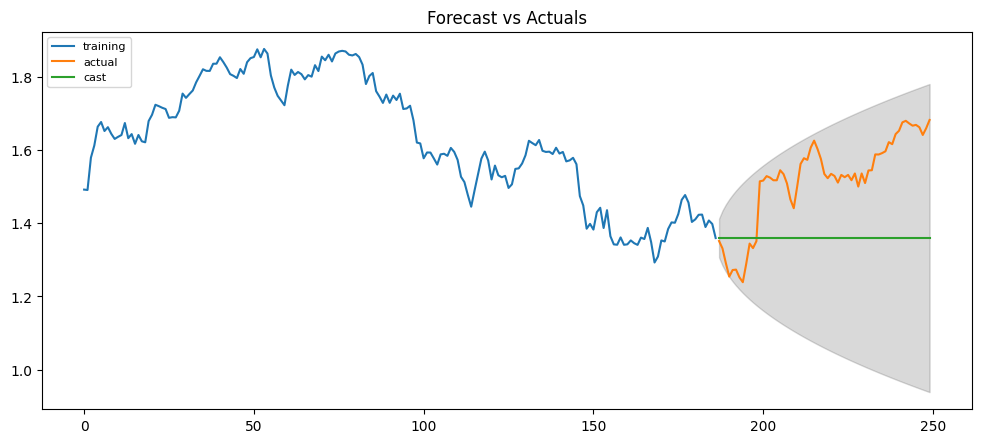

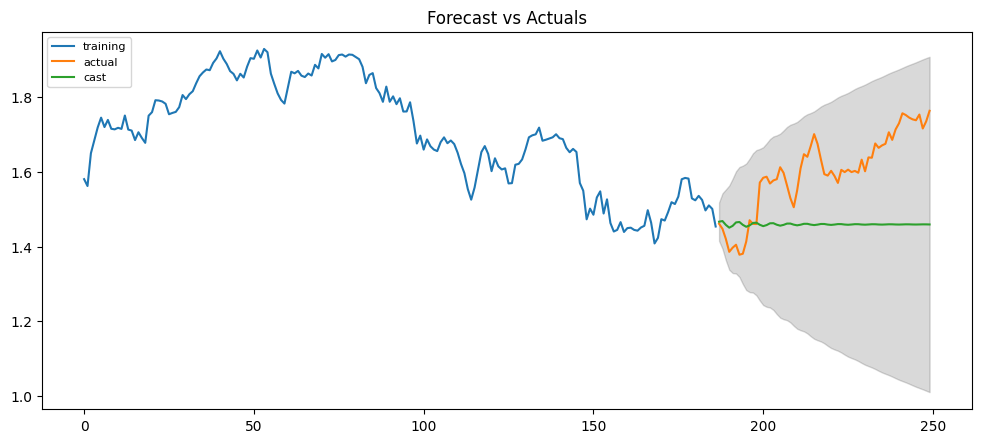

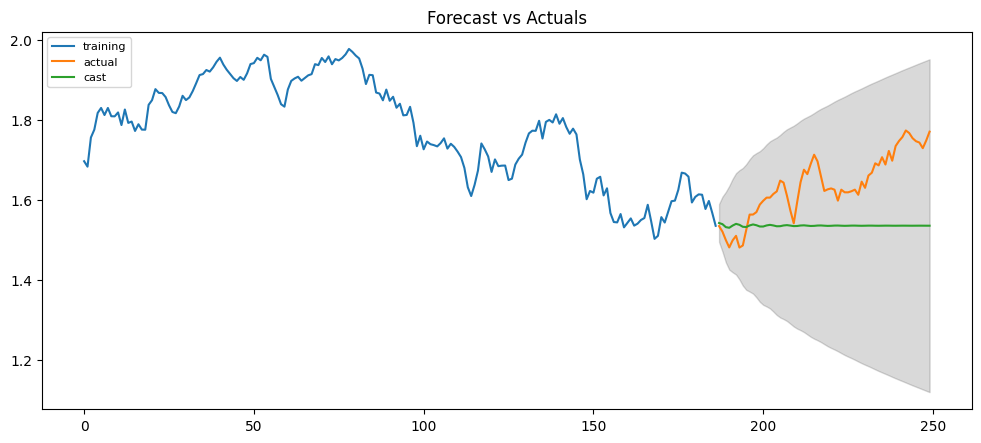

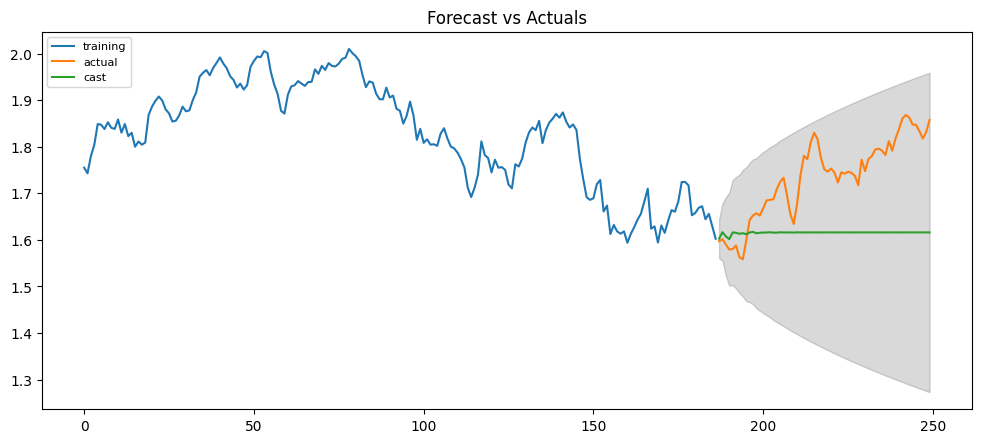

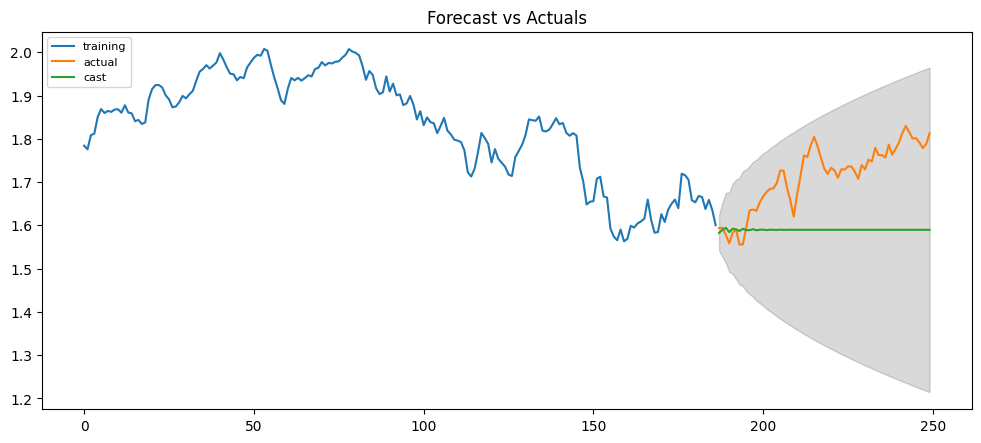

In [297]:
lo = ['lower x5', 'lower x7', 'lower x10', 'lower x20', 'lower x30']
hi = ['upper x5', 'upper x7', 'upper x10', 'upper x20', 'upper x30']

# Forecasts
pd_xx = []
fc_xx = []
fd_xx = []
for f in fit:
    pd_xx.append(f.predict(1, alpha=0.05, dynamic=False))
    fc_xx.append(f.forecast(int(.25*len(data))+1, alpha=0.05))
    fd_xx.append(f.get_forecast(int(.25*len(data))+1, alpha=0.05))

idx = [0, 1, 2, 3, 4]
lower_xx_series = []; upper_xx_series = []
for I in idx:
    lower_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[lo[I]])
    upper_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[hi[I]])

# Plot
for I in idx:
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    # plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'cast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I], 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

### Manual Adjustment of Parameters

The resulting forecast is not as good as expected. No $\text{ARIMA}(p, d, q)$ model works the first time and most require adjustment of the $(p, d, q)$ tuple of parameters.

I define here something known as a **measure of dispersion**. Using the *mean absolute deviation* as a measure of dispersion,

$$
    \text{MAD} = \frac{1}{n} \sum_{i = 1}^{n} |x_i - \bar{X}|
$$

becomes a template for what I need to do next. Although I am using the observations $x_i$, I am not using the average $\bar{X}$, because what I am trying to do is get projections, instead (i.e., the projected forecast based on past data in the time series).

In the subsequent equation, I am including a **measure of relative dispersion**, which will be useful later for comparing across maturities of a given Treasury security, such as

$CV = s / \bar{X}$

I would like to obtain a value, $\text{CV}$, that would yield the dispersion relative to comparable securities, but more on that later. Anyway, I define the function

In [643]:
def maxlike(fc):
    ml = np.abs(test[2] - fc)
    d = {"mad" : [sum(ml) / len(ml)], "cv" : np.std(test) / np.mean(test)}
    return d

which stores the mean absolute dispersion and coefficient of variation in a single Python dictionary. Trying again, with a more informed $\text{ARIMA}$ model-building methodology,

In [577]:
from statsmodels.tsa.arima.model import ARIMA

df         = pd.read_csv("tnf.csv")
idx        = [0, 1, 2, 3, 4]
key        = ['x5', 'x7', 'x10', 'x20', 'x30']

# Create Training
train = []
for i in idx:
    train.append(df[key[i]][:int(.75*len(data))])

# Create Test
test = []
for i in idx:
    test.append(df[key[i]][int(.75*len(data)):])

J = []
j = 63
while j >= 0:
    J.append(j)
    j -= 1
J.sort()

order_lists = []
res = iter(result_df)
for r in res:
    order_lists.append(r["(p, d, q)"])

mods = [[], [], [], [], []]
for i in idx:
    order_list = order_lists[i]
    for j in J:
        mods[i].append(ARIMA(endog=train[i], order=order_list[j]))

fits = [[], [], [], [], []]
for i in idx:
    modc = mods[i]
    for j in J:
        fits[i].append(modc[j].fit())

I replace `fit` with `fits`, which stores $64$ fitted $\text{ARIMA}$ models with the highest AIC. Evaluating that indeed I have $64$ fitted models,

In [579]:
len(fits[0]) == len(fits[1]) == len(fits[2]) == len(fits[3]) == len(fits[4]) == 64

True

I can now find an $\text{ARIMA}$ model which yields the best forecast, given $25\%$ testing data.

In [647]:
fc_xx = [[], [], [], [], []]
for i in idx:
    fit = fits[i]
    for j in J:
        fc_xx[i].append(fit[j].forecast(int(.25*len(data)+1), alpha=0.05))

# ml = [[], [], [], [], []]
ml = [((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0)]
for i in idx:
    for j in J:
        m = maxlike(fc_xx[i][j])
        if m['mad'][0] < ml[i][1]:
            ml[i] = ((i, j), m['mad'][0])
ml

[((0, 62), 0.26576830115464023),
 ((1, 44), 0.1653029163533222),
 ((2, 45), 0.07097753988043586),
 ((3, 5), 0.06158784440932122),
 ((4, 45), 0.061378204132995044)]

I can now print the results of this optimized $\text{ARIMA}(p, d, q)$ model, using the improved, $\text{MAD}$-forecasting approach.

In [649]:
for i in idx:
    print(fits[i][ml[i][0][1]].summary())

                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  187
Model:                 ARIMA(7, 1, 7)   Log Likelihood                 412.899
Date:                Thu, 31 Mar 2022   AIC                           -795.798
Time:                        12:47:52   BIC                           -747.412
Sample:                             0   HQIC                          -776.191
                                - 187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2883      0.543     -0.531      0.595      -1.352       0.776
ar.L2          0.0604      0.259      0.233      0.815      -0.447       0.568
ar.L3          0.3871      0.279      1.390      0.1

Finally, replotting the results,

In [641]:
from statsmodels.tsa.arima.model import ARIMA

df         = pd.read_csv("tnf.csv")
idx        = [0, 1, 2, 3, 4]
key        = ['x5', 'x7', 'x10', 'x20', 'x30']

order_list = [(7, 1, 7), (3, 1, 6), (3, 1, 7), (6, 1, 5), (3, 1, 2)]

# Create Training
train = []
for i in idx:
    train.append(df[key[i]][:int(.75*len(data))])

# Create Test
test = []
for i in idx:
    test.append(df[key[i]][int(.75*len(data)):])

mods = []
for i in idx:
    mods.append(ARIMA(endog=train[i], order=order_list[i]))

fit = []
for mod in mods:
    fit.append(mod.fit())

I have the following:

In [ ]:
lo = ['lower x5', 'lower x7', 'lower x10', 'lower x20', 'lower x30']
hi = ['upper x5', 'upper x7', 'upper x10', 'upper x20', 'upper x30']

# Forecasts
pd_xx = []
fc_xx = []
fd_xx = []
fit   = []

for i in idx:
    fit.append(fits[i][ml[i][0][1]])

for f in fit:
    pd_xx.append(f.predict(1, alpha=0.05, dynamic=False))
    fc_xx.append(f.forecast(int(.25*len(data)+1), alpha=0.05))
    fd_xx.append(f.get_forecast(int(.25*len(data)+1), alpha=0.05))

idx = [0, 1, 2, 3, 4]
lower_xx_series = []; upper_xx_series = []
for I in idx:
    lower_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[lo[I]])
    upper_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[hi[I]])

# Plot
for I in idx:
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'cast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I],
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Conclusion

Despite having gotten closer, my forecasts remain inaccurate. Do I need to use Ordinary Least Squares (OLS) methods, or maybe in the case of $\text{ARIMA}$(p, d, q), simply adding a second order of differencing would be enough?

In `Treas TS Analysis II PII` I will conclude the second section highlighted in the Statement of Purpose and proceed with a discussion of $\text{VARFIMA}$ models for a joint analysis of Treasury Yield Curve Rate data for the year 2019 and conclude with Monte Carlo Markov Chain simulations.